In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

In [2]:
df = pd.read_csv("/content/wine-reviews.csv", usecols = ['country', 'description', 'points', 'price', 'variety', 'winery'])

In [ ]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [3]:
df = df.dropna(subset=["description", "points"])

In [4]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87.0,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87.0,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87.0,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87.0,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87.0,65.0,Pinot Noir,Sweet Cheeks


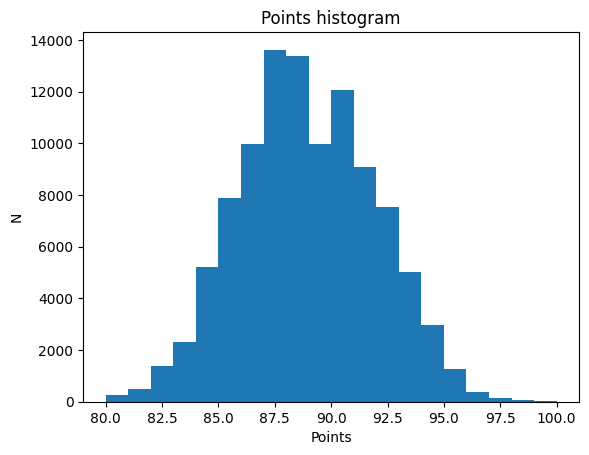

In [5]:
plt.hist(df.points, bins=20)
plt.title("Points histogram")
plt.ylabel("N")
plt.xlabel("Points")
plt.show()

In [6]:
df["label"] = (df.points >= 90).astype(int)
df = df[["description", "label"]]

In [7]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [8]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df["description"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [9]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

# Embedding + Model

In [10]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [11]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.34350756, -0.183215  , -0.01628784, ...,  0.07841626,
        -0.25554776,  0.07208158],
       [ 0.48486128, -0.29644987, -0.07092307, ...,  0.19511127,
        -0.05475348, -0.03053798],
       [ 0.1108128 , -0.20200555, -0.20544876, ..., -0.13179702,
        -0.3226115 ,  0.01603637],
       ...,
       [ 0.24241304, -0.27624527,  0.09430292, ..., -0.0299996 ,
        -0.09697758, -0.02133961],
       [ 0.63689446, -0.25434354, -0.34097096, ..., -0.16984215,
         0.05507122,  0.11951984],
       [ 0.35073292, -0.25438684,  0.06387739, ...,  0.08381953,
        -0.12495149, -0.15143932]], dtype=float32)>

In [23]:
class HubLayerWrapper(tf.keras.layers.Layer):
    def __init__(self, hub_url, **kwargs):
        super(HubLayerWrapper, self).__init__(**kwargs)
        self.hub_layer = hub.KerasLayer(hub_url, dtype=tf.string, trainable=True)

    def call(self, inputs):
        return self.hub_layer(inputs)

input_layer = tf.keras.Input(shape=(), dtype=tf.string)
x = HubLayerWrapper(embedding)(input_layer)  # Use the custom wrapper
x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

In [24]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [25]:
model.evaluate(train_data)

81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6241 - loss: 0.6735


[0.6731356978416443, 0.6248696446418762]

In [26]:
model.evaluate(valid_data)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6268 - loss: 0.6722


[0.6734480261802673, 0.6223084330558777]

In [27]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6079 - loss: 0.6700 - val_accuracy: 0.6234 - val_loss: 0.6486
Epoch 2/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6281 - loss: 0.6466 - val_accuracy: 0.6272 - val_loss: 0.6270
Epoch 3/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6370 - loss: 0.6340 - val_accuracy: 0.6709 - val_loss: 0.6077
Epoch 4/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6608 - loss: 0.6173 - val_accuracy: 0.6903 - val_loss: 0.5958
Epoch 5/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6686 - loss: 0.6067 - val_accuracy: 0.6948 - val_loss: 0.5871


In [28]:
model.evaluate(test_data)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6916 - loss: 0.5876


[0.5875105857849121, 0.6911736130714417]

# LSTM

In [29]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label: text))

In [30]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'it', 'to', 'its', 'on', 'fruit', 'aromas',
       'palate', 'that'], dtype='<U15')

In [31]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [32]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [33]:
model.evaluate(train_data)
model.evaluate(valid_data)

81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 164ms/step - accuracy: 0.4213 - loss: 0.6937
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.4194 - loss: 0.6937


[0.6937032341957092, 0.4194956421852112]

In [34]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 41s 460ms/step - accuracy: 0.6336 - loss: 0.6407 - val_accuracy: 0.7952 - val_loss: 0.4285
Epoch 2/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 34s 413ms/step - accuracy: 0.8215 - loss: 0.3962 - val_accuracy: 0.8307 - val_loss: 0.3709
Epoch 3/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 42s 432ms/step - accuracy: 0.8450 - loss: 0.3506 - val_accuracy: 0.8327 - val_loss: 0.3649
Epoch 4/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 33s 407ms/step - accuracy: 0.8477 - loss: 0.3438 - val_accuracy: 0.8314 - val_loss: 0.3698
Epoch 5/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 34s 424ms/step - accuracy: 0.8479 - loss: 0.3395 - val_accuracy: 0.8330 - val_loss: 0.3716


In [35]:
model.evaluate(test_data)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.8481 - loss: 0.3445


[0.3519487679004669, 0.8433559536933899]